In [ ]:
### In here we perform the initial simple tests. The covariates are all independent gaussian variables. We then plot the
### performance against the change of some crucial parameters

In [1]:
### Some initializations
import numpy as np
import math
import random
import copy
import matplotlib.pyplot as plt
import scipy
from matplotlib.patches import Patch
import scipy.stats
import warnings
import itertools
import loli
import pickle
from scipy.stats import binomtest
from heapq import nlargest
from sklearn.cluster import KMeans

In [2]:
def yerr(tot,res):
    yerrbar=np.zeros((2,len(res)))
    for i in range(len(res)):

        if res[i]>1:
            res[i]=1
        if res[i]<0:
            res[i]=0
        result = binomtest(k=int(res[i]*tot), n=tot, p=res[i])
        yerrbar[0,i]=res[i]-result.proportion_ci()[0]
        yerrbar[1,i]=result.proportion_ci()[1]-res[i]
    return yerrbar

Sample size 1 of 6
Sample size 2 of 6
Sample size 3 of 6
Sample size 4 of 6
Sample size 5 of 6
Sample size 6 of 6


C:\ProgramData\Anaconda3\envs\causal\lib\site-packages\ipykernel_launcher.py:121: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
C:\ProgramData\Anaconda3\envs\causal\lib\site-packages\ipykernel_launcher.py:122: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
C:\ProgramData\Anaconda3\envs\causal\lib\site-packages\ipykernel_launcher.py:123: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
C:\ProgramData\Anaconda3\envs\causal\lib\site-packages\ipykernel_launcher.py:124: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


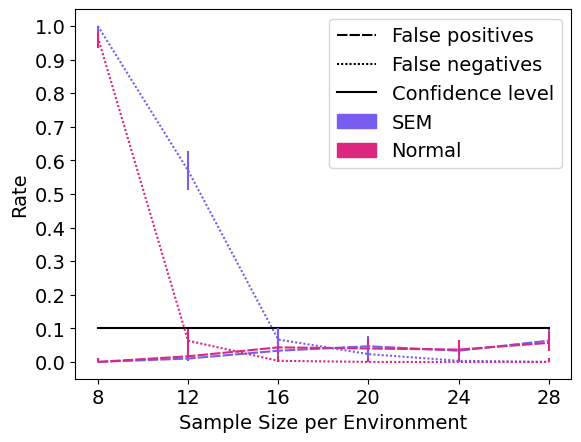

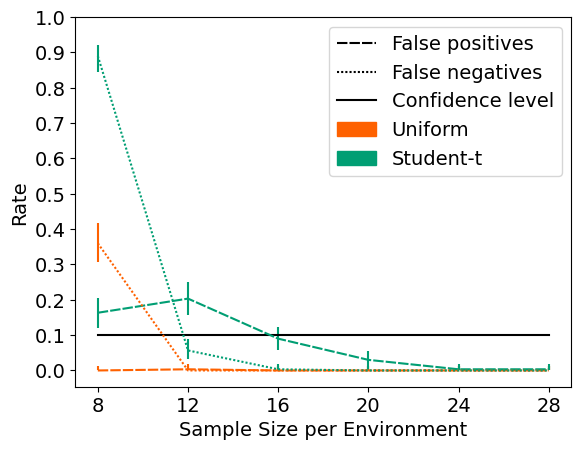

In [3]:
### Changing sample size
for I in [30]:
    np.random.seed(1)
    d=6  #Dimensionality
    supp=(1,2) #support indices
    s=len(supp)  #Number of support entries
    sample=[8,12,16,20,24,28]
    fntrunc=np.zeros((len(sample)))
    fptrunc=np.zeros((len(sample)))
    fnt=np.zeros((len(sample)))
    fpt=np.zeros((len(sample)))
    fnind=np.zeros((len(sample)))
    fpind=np.zeros((len(sample)))
    fn=np.zeros((len(sample)))
    fp=np.zeros((len(sample)))
    runs=300
    l=1 # Number of intervals we combine for the statistics
    B=100 # Bootstrap runs
    a=[list(itertools.combinations(range(d), k)) for k in range(0,d+1)]
    subsets = [item for sublist in a for item in sublist]
    dic={}
    # We first fix the data for all runs, to eliminate the randomness of this.
    betas=np.zeros((runs,I,d))
    for r in range(runs):
        for i in range(I):
            betas[r,i,supp]=np.random.uniform(low=1,high=5,size=(s))

    for o,n in enumerate(sample):
        print('Sample size',o+1,'of',len(sample))
        for r in range(runs):
            X=[]
            Y=[]
            Xind=[]
            Yind=[]
            Xtrunc=[]
            Ytrunc=[]
            Xt=[]
            Yt=[]
            for i in range(I):
                x=np.zeros((n,d))
                y=np.zeros((n))
                std=np.random.uniform(low=1,high=5,size=(d))
                x[:,0]=np.random.normal(scale=std[0],size=(n))
                x[:,1]=x[:,0]+np.random.normal(scale=std[1],size=(n))
                x[:,2]=0.3*x[:,1]+np.random.normal(scale=std[2],size=(n))
                x[:,3]=0.2*x[:,2]+np.random.normal(scale=std[3],size=(n))
                e=np.random.multivariate_normal(0*np.ones(n),2*np.eye(n))
                y=x@betas[r,i,:]+e
                x[:,4]=np.random.normal(scale=std[4],size=(n))+0.1*x[:,1]+y
                x[:,5]=np.random.normal(scale=std[5],size=(n))+y

                X.append(x)
                Y.append(y)

                xind=np.zeros((n,d))
                yind=np.zeros((n))
                ytrunc=np.zeros((n))
                yt=np.zeros((n))
                xtrunc=np.zeros((n,d))
                xt=np.zeros((n,d))

                mean=np.random.uniform(low=-1,high=1,size=(d))
                for p in range(d):
                    xtrunc[:,p]=np.random.uniform(low=-6*std[p]**2,high=6*std[p]**2,size=(n))+mean[p]
                    xt[:,p]=np.random.standard_t(2*(std[p])**(2)/((std[p])**(2)-1),size=(n))+mean[p]
                    xind[:,p]=np.random.normal(mean[p],scale=std[p],size=(n))
                yind=xind@betas[r,i,:]+e
                etrunc=np.random.uniform(low=-6*2**2,high=6*2**2,size=(n))
                ytrunc=xtrunc@betas[r,i,:]+etrunc
                et=np.random.standard_t(2*(2)**(2)/((2)**(2)-1),size=(n))
                yt=xt@betas[r,i,:]+et

                Xind.append(xind)
                Yind.append(yind)
                Xtrunc.append(xtrunc)
                Ytrunc.append(ytrunc)
                Xt.append(xt)
                Yt.append(yt)

            plausibleS=loli.gauss(X,Y)
            if not not plausibleS:
                supphat=set.intersection(*plausibleS)
                if len(supphat.difference(set(supp)))>0:
                    fp[o]+=1/runs
                if len(set(supp).difference(supphat))>0:
                    fn[o]+=1/runs

            plausibleS=loli.gauss(Xind,Yind)
            if not not plausibleS:
                supphat=set.intersection(*plausibleS)
                if len(supphat.difference(set(supp)))>0:
                    fpind[o]+=1/runs
                if len(set(supp).difference(supphat))>0:
                    fnind[o]+=1/runs


            plausibleS=loli.gauss(Xtrunc,Ytrunc)
            if not not plausibleS:
                supphat=set.intersection(*plausibleS)
                if len(supphat.difference(set(supp)))>0:
                    fptrunc[o]+=1/runs
                if len(set(supp).difference(supphat))>0:
                    fntrunc[o]+=1/runs

            plausibleS=loli.gauss(Xt,Yt)
            if not not plausibleS:
                supphat=set.intersection(*plausibleS)
                if len(supphat.difference(set(supp)))>0:
                    fpt[o]+=1/runs
                if len(set(supp).difference(supphat))>0:
                    fnt[o]+=1/runs
        
    fig, ax = plt.subplots()
    plt.xticks(sample)
    plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(14)

    false_pos = plt.Line2D([], [], color='black', linestyle=(0, (5, 1)),label='False positives')
    false_neg = plt.Line2D([], [], color='black', linestyle=(0, (1, 1)),label='False negatives')
    sem = Patch([], [], color='#785EF0',label='SEM')
    normal = Patch([], [], color='#DC267F',label='Normal')
    trunc = Patch([], [], color='#FE6100',label='Uniform')
    student = Patch([], [], color='#009E73',label='Student-t')
    conf= plt.Line2D([], [], color='black',label='Confidence level')

    plt.plot(sample,0.1*np.ones((len(sample))),label='Confidence level',color='black')
    plt.errorbar(sample,fp,yerr=yerr(runs,fp),c='#785EF0',label='False Positive SEM',linestyle=(0, (5, 1)))
    plt.errorbar(sample,fpind,yerr=yerr(runs,fpind),c='#DC267F',label='False Positive Normal',linestyle=(0, (5, 1)))
    plt.errorbar(sample,fn,yerr=yerr(runs,fn),c='#785EF0',label='False Negative SEM',linestyle=(0, (1, 1)))
    plt.errorbar(sample,fnind,yerr=yerr(runs,fnind),c='#DC267F',label='False Negative Normal',linestyle=(0, (1, 1)))
    false_pos = plt.Line2D([], [], color='black', linestyle=(0, (5, 1)),label='False positives')
    false_neg = plt.Line2D([], [], color='black', linestyle=(0, (1, 1)),label='False negatives')
    ax.legend(handles=[false_pos,false_neg,conf,sem,normal],fontsize=14)
    plt.xlabel('Sample Size per Environment',fontsize=14)
    plt.ylabel('Rate',fontsize=14)
#     plt.savefig('Figures/SamplechangSem='+str(I)+'.pdf',bbox_inches="tight",format='pdf')
    plt.show()



    fig, ax = plt.subplots()
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(14)
    plt.errorbar(sample,0.1*np.ones((len(sample))),label='Confidence level',color='black')
    plt.errorbar(sample,fptrunc,yerr=yerr(runs,fptrunc),c='#FE6100',label='False Positive Truncated',linestyle=(0, (5, 1)))
    plt.errorbar(sample,fpt,yerr=yerr(runs,fpt),c='#009E73',label='False Positive Student-t',linestyle=(0, (5, 1)))
    plt.errorbar(sample,fntrunc,yerr=yerr(runs,fntrunc),c='#FE6100',label='False Negative Truncated',linestyle=(0, (1, 1)))
    plt.errorbar(sample,fnt,yerr=yerr(runs,fnt),c='#009E73',label='False Negative Student-t',linestyle=(0, (1, 1)))
    false_pos = plt.Line2D([], [], color='black', linestyle=(0, (5, 1)),label='False positives')
    false_neg = plt.Line2D([], [], color='black', linestyle=(0, (1, 1)),label='False negatives')
    ax.legend(handles=[false_pos,false_neg,conf,trunc,student],fontsize=14)
    plt.xlabel('Sample Size per Environment',fontsize=14)
    plt.xticks(sample)
    plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
    plt.ylabel('Rate',fontsize=14)
#     plt.savefig('Figures/SamplechangNonNormalE='+str(I)+'.pdf',bbox_inches="tight",format='pdf')
    plt.show()
    
SamplechangeE30={}
SamplechangeE30['fpt']=fpt
SamplechangeE30['fnt']=fnt
SamplechangeE30['fptrunc']=fptrunc
SamplechangeE30['fntrunc']=fntrunc
SamplechangeE30['fp']=fp
SamplechangeE30['fn']=fn
SamplechangeE30['fpind']=fpind
SamplechangeE30['fnind']=fnind
SamplechangeE30['sample']=sample

# with open('SamplechangeE30.pkl', 'wb') as f:
#     pickle.dump(SamplechangeE30, f)

In [4]:
fpind

array([0.        , 0.01666667, 0.04333333, 0.04      , 0.03666667,
       0.05666667])

In [ ]:
### Changing noise strength
for I in [30]:
    np.random.seed(1)
    d=6  #Dimensionality
    supp=(1,2) #support indices
    s=len(supp)  #Number of support entries
    noise=[0,18,38,58,78]
    fntrunc=np.zeros((len(noise)))
    fptrunc=np.zeros((len(noise)))
    fnt=np.zeros((len(noise)))
    fpt=np.zeros((len(noise)))
    fnind=np.zeros((len(noise)))
    fpind=np.zeros((len(noise)))
    fn=np.zeros((len(noise)))
    fp=np.zeros((len(noise)))
    runs=300
    l=1 # Number of intervals we combine for the statistics
    B=100 # Bootstrap runs
    n=15
    a=[list(itertools.combinations(range(d), k)) for k in range(0,d+1)]
    subsets = [item for sublist in a for item in sublist]
    dic={}
    # We first fix the data for all runs, to eliminate the randomness of this.
    betas=np.zeros((runs,I,d))
    for r in range(runs):
        for i in range(I):
            betas[r,i,supp]=np.random.uniform(low=1,high=5,size=(s))

    for o,nos in enumerate(noise):
        print('Noise strength',o+1,'of',len(noise))
        for r in range(runs):
            X=[]
            Y=[]
            Xind=[]
            Yind=[]
            Xtrunc=[]
            Ytrunc=[]
            Xt=[]
            Yt=[]
            for i in range(I):
                x=np.zeros((n,d))
                y=np.zeros((n))
                std=np.random.uniform(low=1,high=5,size=(d))
                x[:,0]=np.random.normal(scale=std[0],size=(n))
                x[:,1]=x[:,0]+np.random.normal(scale=std[1],size=(n))
                x[:,2]=0.3*x[:,1]+np.random.normal(scale=std[2],size=(n))
                x[:,3]=0.2*x[:,2]+np.random.normal(scale=std[3],size=(n))
                e=np.random.multivariate_normal(0*np.ones(n),(2+nos)*np.eye(n))
                y=x@betas[r,i,:]+e
                x[:,4]=np.random.normal(scale=std[4],size=(n))+0.1*x[:,1]+y
                x[:,5]=np.random.normal(scale=std[5],size=(n))+y

                X.append(x)
                Y.append(y)

                xind=np.zeros((n,d))
                yind=np.zeros((n))
                ytrunc=np.zeros((n))
                yt=np.zeros((n))
                xtrunc=np.zeros((n,d))
                xt=np.zeros((n,d))

                mean=np.random.uniform(low=-1,high=1,size=(d))


                for p in range(d):
                    xtrunc[:,p]=np.random.uniform(low=-6*std[p]**2,high=6*std[p]**2,size=(n))+mean[p]
                    xt[:,p]=np.random.standard_t(2*(std[p])**(2)/((std[p])**(2)-1),size=(n))+mean[p]
                    xind[:,p]=np.random.normal(mean[p],scale=std[p],size=(n))
                yind=xind@betas[r,i,:]+e
                etrunc=np.random.uniform(low=-6*(2+nos)**2,high=6*(2+nos)**2,size=(n))
                ytrunc=xtrunc@betas[r,i,:]+etrunc
                et=np.random.standard_t(2*((2+nos))**(2)/(((2+nos))**(2)-1),size=(n))
                yt=xt@betas[r,i,:]+et


                Xind.append(xind)
                Yind.append(yind)
                Xtrunc.append(xtrunc)
                Ytrunc.append(ytrunc)
                Xt.append(xt)
                Yt.append(yt)

            plausibleS=loli.gauss(X,Y)
            if not not plausibleS:
                supphat=set.intersection(*plausibleS)
                if len(supphat.difference(set(supp)))>0:
                    fp[o]+=1/runs
                if len(set(supp).difference(supphat))>0:
                    fn[o]+=1/runs

            plausibleS=loli.gauss(Xind,Yind)
            if not not plausibleS:
                supphat=set.intersection(*plausibleS)
                if len(supphat.difference(set(supp)))>0:
                    fpind[o]+=1/runs
                if len(set(supp).difference(supphat))>0:
                    fnind[o]+=1/runs


            plausibleS=loli.gauss(Xtrunc,Ytrunc)
            if not not plausibleS:
                supphat=set.intersection(*plausibleS)
                if len(supphat.difference(set(supp)))>0:
                    fptrunc[o]+=1/runs
                if len(set(supp).difference(supphat))>0:
                    fntrunc[o]+=1/runs

            plausibleS=loli.gauss(Xt,Yt)
            if not not plausibleS:
                supphat=set.intersection(*plausibleS)
                if len(supphat.difference(set(supp)))>0:
                    fpt[o]+=1/runs
                if len(set(supp).difference(supphat))>0:
                    fnt[o]+=1/runs

    fig, ax = plt.subplots()
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(14)

    false_pos = plt.Line2D([], [], color='black', linestyle=(0, (5, 1)),label='False positives')
    false_neg = plt.Line2D([], [], color='black', linestyle=(0, (1, 1)),label='False negatives')
    sem = Patch([], [], color='#785EF0',label='SEM')
    normal = Patch([], [], color='#DC267F',label='Normal')
    trunc = Patch([], [], color='#FE6100',label='Uniform')
    student = Patch([], [], color='#009E73',label='Student-t')
    conf= plt.Line2D([], [], color='black',label='Confidence level')

    plt.plot(noise,0.1*np.ones((len(noise))),label='Confidence level',color='black')
    plt.errorbar(noise,fp,yerr=yerr(runs,fp),c='#785EF0',label='False Positive SEM',linestyle=(0, (5, 1)))
    plt.errorbar(noise,fpind,yerr=yerr(runs,fpind),c='#DC267F',label='False Positive Normal',linestyle=(0, (5, 1)))
    plt.errorbar(noise,fn,yerr=yerr(runs,fn),c='#785EF0',label='False Negative SEM',linestyle=(0, (1, 1)))
    plt.errorbar(noise,fnind,yerr=yerr(runs,fnind),c='#DC267F',label='False Negative Normal',linestyle=(0, (1, 1)))
    false_pos = plt.Line2D([], [], color='black', linestyle=(0, (5, 1)),label='False positives')
    false_neg = plt.Line2D([], [], color='black', linestyle=(0, (1, 1)),label='False negatives')
    ax.legend(handles=[false_pos,false_neg,conf,sem,normal],fontsize=14)
    plt.xticks(np.array(noise)+2)
    plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
    plt.xlabel('Standard Deviation of Target Noise',fontsize=14)
    plt.ylabel('Rate',fontsize=14)
    plt.savefig('Figures/NoisechangSem='+str(I)+'.pdf',bbox_inches="tight",format='pdf')
    plt.show()


    fig, ax = plt.subplots()
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(14)
    plt.errorbar(noise,0.1*np.ones((len(noise))),label='Confidence level',color='black')
    plt.errorbar(noise,fptrunc,yerr=yerr(runs,fptrunc),c='#FE6100',label='False Positive Truncated',linestyle=(0, (5, 1)))
    plt.errorbar(noise,fpt,yerr=yerr(runs,fpt),c='#009E73',label='False Positive Student-t',linestyle=(0, (5, 1)))
    plt.errorbar(noise,fntrunc,yerr=yerr(runs,fntrunc),c='#FE6100',label='False Negative Truncated',linestyle=(0, (1, 1)))
    plt.errorbar(noise,fnt,yerr=yerr(runs,fnt),c='#009E73',label='False Negative Student-t',linestyle=(0, (1, 1)))
    false_pos = plt.Line2D([], [], color='black', linestyle=(0, (5, 1)),label='False positives')
    false_neg = plt.Line2D([], [], color='black', linestyle=(0, (1, 1)),label='False negatives')
    ax.legend(handles=[false_pos,false_neg,conf,trunc,student],fontsize=14)
    plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
    plt.xticks(np.array(noise)+2)
    plt.xlabel('Standard Deviation of Target Noise',fontsize=14)
    plt.ylabel('Rate',fontsize=14)
    plt.savefig('Figures/NoisechangNonNormalE='+str(I)+'.pdf',bbox_inches="tight",format='pdf')
    plt.show()
    
NoisechangeE30={}
NoisechangeE30['fpt']=fpt
NoisechangeE30['fnt']=fnt
NoisechangeE30['fptrunc']=fptrunc
NoisechangeE30['fntrunc']=fntrunc
NoisechangeE30['fp']=fp
NoisechangeE30['fn']=fn
NoisechangeE30['fpind']=fpind
NoisechangeE30['fnind']=fnind
NoisechangeE30['noise']=noise

with open('NoisechangeE30.pkl', 'wb') as f:
    pickle.dump(NoisechangeE30, f)

In [ ]:
### Changing number of environments for n=10
n=10
np.random.seed(1)
d=6  #Dimensionality
supp=(1,2) #support indices
s=len(supp)  #Number of support entries
environments=[2,40,80,120,160,200,240]
fntrunc=np.zeros((len(environments)))
fptrunc=np.zeros((len(environments)))
fnt=np.zeros((len(environments)))
fpt=np.zeros((len(environments)))
fnind=np.zeros((len(environments)))
fpind=np.zeros((len(environments)))
fn=np.zeros((len(environments)))
fp=np.zeros((len(environments)))
runs=300
l=1 # Number of intervals we combine for the statistics
B=100 # Bootstrap runs
I=environments[-1]      #Number of Intervals 
a=[list(itertools.combinations(range(d), k)) for k in range(0,d+1)]
subsets = [item for sublist in a for item in sublist]
dic={}
# We first fix the data for all runs, to eliminate the randomness of this.
betas=np.zeros((runs,I,d))
for r in range(runs):
    for i in range(I):
        betas[r,i,supp]=np.random.uniform(low=1,high=5,size=(s))

for o,I in enumerate(environments):
    print('Environment size',o+1,'of',len(environments))
    for r in range(runs):
        X=[]
        Y=[]
        Xind=[]
        Yind=[]
        Xtrunc=[]
        Ytrunc=[]
        Xt=[]
        Yt=[]
        for i in range(I):
            x=np.zeros((n,d))
            y=np.zeros((n))
            std=np.random.uniform(low=1,high=5,size=(d))
            x[:,0]=np.random.normal(scale=std[0],size=(n))
            x[:,1]=x[:,0]+np.random.normal(scale=std[1],size=(n))
            x[:,2]=0.3*x[:,1]+np.random.normal(scale=std[2],size=(n))
            x[:,3]=0.2*x[:,2]+np.random.normal(scale=std[3],size=(n))
            e=np.random.multivariate_normal(0*np.ones(n),(2)*np.eye(n))
            y=x@betas[r,i,:]+e
            x[:,4]=np.random.normal(scale=std[4],size=(n))+0.1*x[:,1]+y
            x[:,5]=np.random.normal(scale=std[5],size=(n))+y

            X.append(x)
            Y.append(y)

            xind=np.zeros((n,d))
            yind=np.zeros((n))
            ytrunc=np.zeros((n))
            yt=np.zeros((n))
            xtrunc=np.zeros((n,d))
            xt=np.zeros((n,d))

            mean=np.random.uniform(low=-1,high=1,size=(d))


            for p in range(d):
                xtrunc[:,p]=np.random.uniform(low=-6*std[p]**2,high=6*std[p]**2,size=(n))+mean[p]
                xt[:,p]=np.random.standard_t(2*(std[p])**(2)/((std[p])**(2)-1),size=(n))+mean[p]
                xind[:,p]=np.random.normal(mean[p],scale=std[p],size=(n))
            yind=xind@betas[r,i,:]+e
            etrunc=np.random.uniform(low=-6*(2)**2,high=6*(2)**2,size=(n))
            ytrunc=xtrunc@betas[r,i,:]+etrunc
            et=np.random.standard_t(2*((2))**(2)/(((2))**(2)-1),size=(n))
            yt=xt@betas[r,i,:]+et


            Xind.append(xind)
            Yind.append(yind)
            Xtrunc.append(xtrunc)
            Ytrunc.append(ytrunc)
            Xt.append(xt)
            Yt.append(yt)

        plausibleS=loli.gauss(X,Y)
        if not not plausibleS:
            supphat=set.intersection(*plausibleS)
            if len(supphat.difference(set(supp)))>0:
                fp[o]+=1/runs
            if len(set(supp).difference(supphat))>0:
                fn[o]+=1/runs

        plausibleS=loli.gauss(Xind,Yind)
        if not not plausibleS:
            supphat=set.intersection(*plausibleS)
            if len(supphat.difference(set(supp)))>0:
                fpind[o]+=1/runs
            if len(set(supp).difference(supphat))>0:
                fnind[o]+=1/runs


        plausibleS=loli.gauss(Xtrunc,Ytrunc)
        if not not plausibleS:
            supphat=set.intersection(*plausibleS)
            if len(supphat.difference(set(supp)))>0:
                fptrunc[o]+=1/runs
            if len(set(supp).difference(supphat))>0:
                fntrunc[o]+=1/runs

        plausibleS=loli.gauss(Xt,Yt)
        if not not plausibleS:
            supphat=set.intersection(*plausibleS)
            if len(supphat.difference(set(supp)))>0:
                fpt[o]+=1/runs
            if len(set(supp).difference(supphat))>0:
                fnt[o]+=1/runs

fig, ax = plt.subplots()
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(14)

false_pos = plt.Line2D([], [], color='black', linestyle=(0, (5, 1)),label='False positives')
false_neg = plt.Line2D([], [], color='black', linestyle=(0, (1, 1)),label='False negatives')
sem = Patch([], [], color='#785EF0',label='SEM')
normal = Patch([], [], color='#DC267F',label='Normal')
trunc = Patch([], [], color='#FE6100',label='Uniform')
student = Patch([], [], color='#009E73',label='Student-t')
conf= plt.Line2D([], [], color='black',label='Confidence level')

plt.plot(environments,0.1*np.ones((len(environments))),label='Confidence level',color='black')
plt.errorbar(environments,fp,yerr=yerr(runs,fp),c='#785EF0',label='False Positive SEM',linestyle=(0, (5, 1)))
plt.errorbar(environments,fpind,yerr=yerr(runs,fpind),c='#DC267F',label='False Positive Normal',linestyle=(0, (5, 1)))
plt.errorbar(environments,fn,yerr=yerr(runs,fn),c='#785EF0',label='False Negative SEM',linestyle=(0, (1, 1)))
plt.errorbar(environments,fnind,yerr=yerr(runs,fnind),c='#DC267F',label='False Negative Normal',linestyle=(0, (1, 1)))
false_pos = plt.Line2D([], [], color='black', linestyle=(0, (5, 1)),label='False positives')
false_neg = plt.Line2D([], [], color='black', linestyle=(0, (1, 1)),label='False negatives')
ax.legend(handles=[false_pos,false_neg,conf,sem,normal],fontsize=14)
plt.xticks(environments)
plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.xlabel('Amount of Environments',fontsize=14)
plt.ylabel('Rate',fontsize=14)
plt.savefig('Figures/EnvironmentchangSemN='+str(n)+'.eps',bbox_inches="tight",format='eps')
plt.show()


fig, ax = plt.subplots()
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(14)
plt.errorbar(environments,0.1*np.ones((len(environments))),label='Confidence level',color='black')
plt.errorbar(environments,fptrunc,yerr=yerr(runs,fptrunc),c='#FE6100',label='False Positive Truncated',linestyle=(0, (5, 1)))
plt.errorbar(environments,fpt,yerr=yerr(runs,fpt),c='#009E73',label='False Positive Student-t',linestyle=(0, (5, 1)))
plt.errorbar(environments,fntrunc,yerr=yerr(runs,fntrunc),c='#FE6100',label='False Negative Truncated',linestyle=(0, (1, 1)))
plt.errorbar(environments,fnt,yerr=yerr(runs,fnt),c='#009E73',label='False Negative Student-t',linestyle=(0, (1, 1)))
false_pos = plt.Line2D([], [], color='black', linestyle=(0, (5, 1)),label='False positives')
false_neg = plt.Line2D([], [], color='black', linestyle=(0, (1, 1)),label='False negatives')
ax.legend(handles=[false_pos,false_neg,conf,trunc,student],fontsize=14)
plt.xticks(environments)
plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.xlabel('Amount of Environments',fontsize=14)
plt.ylabel('Rate',fontsize=14)
plt.savefig('Figures/EnvironmentchangNonNormalN='+str(n)+'.eps',bbox_inches="tight",format='eps')
plt.show()

EnvironmentchangN10={}
EnvironmentchangN10['fpt']=fpt
EnvironmentchangN10['fnt']=fnt
EnvironmentchangN10['fptrunc']=fptrunc
EnvironmentchangN10['fntrunc']=fntrunc
EnvironmentchangN10['fp']=fp
EnvironmentchangN10['fn']=fn
EnvironmentchangN10['fpind']=fpind
EnvironmentchangN10['fnind']=fnind
EnvironmentchangN10['environments']=environments

with open('EnvironmentchangN10.pkl', 'wb') as f:
    pickle.dump(EnvironmentchangN10, f)

In [ ]:
### Changing number of environments for n=14
n=14
np.random.seed(1)
d=6  #Dimensionality
supp=(1,2) #support indices
s=len(supp)  #Number of support entries
environments=[2,40,80,120,160,200,240]
fntrunc=np.zeros((len(environments)))
fptrunc=np.zeros((len(environments)))
fnt=np.zeros((len(environments)))
fpt=np.zeros((len(environments)))
fnind=np.zeros((len(environments)))
fpind=np.zeros((len(environments)))
fn=np.zeros((len(environments)))
fp=np.zeros((len(environments)))
runs=300
l=1 # Number of intervals we combine for the statistics
B=100 # Bootstrap runs
I=environments[-1]      #Number of Intervals 
a=[list(itertools.combinations(range(d), k)) for k in range(0,d+1)]
subsets = [item for sublist in a for item in sublist]
dic={}
# We first fix the data for all runs, to eliminate the randomness of this.
betas=np.zeros((runs,I,d))
for r in range(runs):
    for i in range(I):
        betas[r,i,supp]=np.random.uniform(low=1,high=5,size=(s))

for o,I in enumerate(environments):
    print('Environment size',o+1,'of',len(environments))
    for r in range(runs):
        X=[]
        Y=[]
        Xind=[]
        Yind=[]
        Xtrunc=[]
        Ytrunc=[]
        Xt=[]
        Yt=[]
        for i in range(I):
            x=np.zeros((n,d))
            y=np.zeros((n))
            std=np.random.uniform(low=1,high=5,size=(d))
            x[:,0]=np.random.normal(scale=std[0],size=(n))
            x[:,1]=x[:,0]+np.random.normal(scale=std[1],size=(n))
            x[:,2]=0.3*x[:,1]+np.random.normal(scale=std[2],size=(n))
            x[:,3]=0.2*x[:,2]+np.random.normal(scale=std[3],size=(n))
            e=np.random.multivariate_normal(0*np.ones(n),(2)*np.eye(n))
            y=x@betas[r,i,:]+e
            x[:,4]=np.random.normal(scale=std[4],size=(n))+0.1*x[:,1]+y
            x[:,5]=np.random.normal(scale=std[5],size=(n))+y

            X.append(x)
            Y.append(y)

            xind=np.zeros((n,d))
            yind=np.zeros((n))
            ytrunc=np.zeros((n))
            yt=np.zeros((n))
            xtrunc=np.zeros((n,d))
            xt=np.zeros((n,d))

            mean=np.random.uniform(low=-1,high=1,size=(d))


            for p in range(d):
                xtrunc[:,p]=np.random.uniform(low=-6*std[p]**2,high=6*std[p]**2,size=(n))+mean[p]
                xt[:,p]=np.random.standard_t(2*(std[p])**(2)/((std[p])**(2)-1),size=(n))+mean[p]
                xind[:,p]=np.random.normal(mean[p],scale=std[p],size=(n))
            yind=xind@betas[r,i,:]+e
            etrunc=np.random.uniform(low=-6*(2)**2,high=6*(2)**2,size=(n))
            ytrunc=xtrunc@betas[r,i,:]+etrunc
            et=np.random.standard_t(2*((2))**(2)/(((2))**(2)-1),size=(n))
            yt=xt@betas[r,i,:]+et


            Xind.append(xind)
            Yind.append(yind)
            Xtrunc.append(xtrunc)
            Ytrunc.append(ytrunc)
            Xt.append(xt)
            Yt.append(yt)

        plausibleS=loli.gauss(X,Y)
        if not not plausibleS:
            supphat=set.intersection(*plausibleS)
            if len(supphat.difference(set(supp)))>0:
                fp[o]+=1/runs
            if len(set(supp).difference(supphat))>0:
                fn[o]+=1/runs

        plausibleS=loli.gauss(Xind,Yind)
        if not not plausibleS:
            supphat=set.intersection(*plausibleS)
            if len(supphat.difference(set(supp)))>0:
                fpind[o]+=1/runs
            if len(set(supp).difference(supphat))>0:
                fnind[o]+=1/runs


        plausibleS=loli.gauss(Xtrunc,Ytrunc)
        if not not plausibleS:
            supphat=set.intersection(*plausibleS)
            if len(supphat.difference(set(supp)))>0:
                fptrunc[o]+=1/runs
            if len(set(supp).difference(supphat))>0:
                fntrunc[o]+=1/runs

        plausibleS=loli.gauss(Xt,Yt)
        if not not plausibleS:
            supphat=set.intersection(*plausibleS)
            if len(supphat.difference(set(supp)))>0:
                fpt[o]+=1/runs
            if len(set(supp).difference(supphat))>0:
                fnt[o]+=1/runs

fig, ax = plt.subplots()
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(14)

false_pos = plt.Line2D([], [], color='black', linestyle=(0, (5, 1)),label='False positives')
false_neg = plt.Line2D([], [], color='black', linestyle=(0, (1, 1)),label='False negatives')
sem = Patch([], [], color='#785EF0',label='SEM')
normal = Patch([], [], color='#DC267F',label='Normal')
trunc = Patch([], [], color='#FE6100',label='Uniform')
student = Patch([], [], color='#009E73',label='Student-t')
conf= plt.Line2D([], [], color='black',label='Confidence level')

plt.plot(environments,0.1*np.ones((len(environments))),label='Confidence level',color='black')
plt.errorbar(environments,fp,yerr=yerr(runs,fp),c='#785EF0',label='False Positive SEM',linestyle=(0, (5, 1)))
plt.errorbar(environments,fpind,yerr=yerr(runs,fpind),c='#DC267F',label='False Positive Normal',linestyle=(0, (5, 1)))
plt.errorbar(environments,fn,yerr=yerr(runs,fn),c='#785EF0',label='False Negative SEM',linestyle=(0, (1, 1)))
plt.errorbar(environments,fnind,yerr=yerr(runs,fnind),c='#DC267F',label='False Negative Normal',linestyle=(0, (1, 1)))
false_pos = plt.Line2D([], [], color='black', linestyle=(0, (5, 1)),label='False positives')
false_neg = plt.Line2D([], [], color='black', linestyle=(0, (1, 1)),label='False negatives')
ax.legend(handles=[false_pos,false_neg,conf,sem,normal],fontsize=14)
plt.xticks(environments)
plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.xlabel('Amount of Environments',fontsize=14)
plt.ylabel('Rate',fontsize=14)
plt.savefig('Figures/EnvironmentchangSemN='+str(n)+'.eps',bbox_inches="tight",format='eps')
plt.show()


fig, ax = plt.subplots()
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(14)
plt.errorbar(environments,0.1*np.ones((len(environments))),label='Confidence level',color='black')
plt.errorbar(environments,fptrunc,yerr=yerr(runs,fptrunc),c='#FE6100',label='False Positive Truncated',linestyle=(0, (5, 1)))
plt.errorbar(environments,fpt,yerr=yerr(runs,fpt),c='#009E73',label='False Positive Student-t',linestyle=(0, (5, 1)))
plt.errorbar(environments,fntrunc,yerr=yerr(runs,fntrunc),c='#FE6100',label='False Negative Truncated',linestyle=(0, (1, 1)))
plt.errorbar(environments,fnt,yerr=yerr(runs,fnt),c='#009E73',label='False Negative Student-t',linestyle=(0, (1, 1)))
false_pos = plt.Line2D([], [], color='black', linestyle=(0, (5, 1)),label='False positives')
false_neg = plt.Line2D([], [], color='black', linestyle=(0, (1, 1)),label='False negatives')
ax.legend(handles=[false_pos,false_neg,conf,trunc,student],fontsize=14)
plt.xticks(environments)
plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.xlabel('Amount of Environments',fontsize=14)
plt.ylabel('Rate',fontsize=14)
plt.savefig('Figures/EnvironmentchangNonNormalN='+str(n)+'.eps',bbox_inches="tight",format='eps')
plt.show()

EnvironmentchangN14={}
EnvironmentchangN14['fpt']=fpt
EnvironmentchangN14['fnt']=fnt
EnvironmentchangN14['fptrunc']=fptrunc
EnvironmentchangN14['fntrunc']=fntrunc
EnvironmentchangN14['fp']=fp
EnvironmentchangN14['fn']=fn
EnvironmentchangN14['fpind']=fpind
EnvironmentchangN14['fnind']=fnind
EnvironmentchangN14['environments']=environments

with open('EnvironmentchangN14.pkl', 'wb') as f:
    pickle.dump(EnvironmentchangN14, f)